In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from chissl import chissl_mongo as cm
%load_ext autoreload
%autoreload 2

# Process the 20 Newsgroups Dataset

In [3]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()

def parse_document(s):
    header, content = s.split('\n\n', 1)
    source, title, _ = header.split('\n', 2)
    return {'source': source.replace('From:', ''),
            'title': title.replace('Subject: ', ''),
            'content': content.strip()}

targets = {
 'comp.os.ms-windows.misc'  : 'Software',
 'comp.windows.x'           : 'Software',
 'comp.sys.ibm.pc.hardware' : 'Hardware',
 'comp.sys.mac.hardware'    : 'Hardware',
 'misc.forsale'             : 'For sale',
 'rec.autos'                : 'Autos',
 'rec.motorcycles'          : 'Autos',
 'rec.sport.baseball'       : 'Sports',
 'rec.sport.hockey'         : 'Sports',
 'sci.med'                  : 'Medicine',
 'sci.space'                : 'Space'
}

df = pd.DataFrame(list(map(parse_document, data.data)))
df['_id'] = np.arange(len(df)).astype('str')
df['group'] = [targets.get(x, 'None') for x in np.array(data.target_names)[data.target]]
df = df[df.group != 'None'].reset_index(drop=True)
df.head()

,source,title,content,_id,group
0,lerxst@wam.umd.edu (where's my thing),WHAT car is this!?,I was wondering if anyone out there could enli...,0,Autos
1,guykuo@carson.u.washington.edu (Guy Kuo),SI Clock Poll - Final Call,A fair number of brave souls who upgraded thei...,1,Hardware
2,twillis@ec.ecn.purdue.edu (Thomas E Willis),PB questions...,"well folks, my mac plus finally gave up the gh...",2,Hardware
3,jcm@head-cfa.harvard.edu (Jonathan McDowell),Re: Shuttle Launch Question,"From article <C5owCB.n3p@world.std.com>, by to...",4,Space
4,bmdelane@quads.uchicago.edu (brian manning de...,Brain Tumor Treatment (thanks),There were a few people who responded to my re...,6,Medicine


# Add text documents to database

In [4]:
cm.ChisslMongo().create_collection('Newsgroups', df.to_dict(orient='records'), drop=True)

# Create a Newsgroups application

In [5]:
cm.ChisslMongo()\
    .create_application('20 Newsgroups (nmf)',
                        'Newsgroups',
                        'NewsgroupsComponent',
                        'chissl.pipelines.text.TextPipeline',
                         params={'umap__metric': 'cosine'},
                         drop=True)

{'_id': '20 Newsgroups (nmf)',
 'collection': 'Newsgroups',
 'component': 'NewsgroupsComponent',
 'pipeline': 'chissl.pipelines.text.TextPipeline',
 'props': {},
 'params': {'umap__metric': 'cosine'}}

# Fit a model

In [6]:
obj = cm.ChisslMongo(verbose=True)\
    .create_model('20 Newsgroups (nmf)', 'test',
                  project={'group': True},
                  drop=True)

Finding application <20 Newsgroups (nmf)>...OK
Querying collection <Newsgroups> <None>...found 6513...OK
Transforming data...Pipeline(memory=None,
         steps=[('tfidf', JSONTfidfVectorizer(field='content')),
                ('nmf',
                 NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0,
                     max_iter=200, n_components=30, random_state=None,
                     shuffle=False, solver='cd', tol=0.0001, verbose=0)),
                ('norm', Normalizer(copy=True, norm='l1'))],
         verbose=False)...

C:\Users\gabri\Anaconda3\lib\site-packages\umap\rp_tree.py:469: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_angular_tree" failed type inference due to: Invalid use of recursive(type(CPUDispatcher(<function make_angular_tree at 0x0000015AB3D3BD90>))) with parameters (array(float32, 2d, C), array(int64, 1d, C), array(int64, 1d, C), int64)
No type info available for recursive(type(CPUDispatcher(<function make_angular_tree at 0x0000015AB3D3BD90>))) as a callable.
[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_angular_tree at 0x0000015AB3D3BD90>)))
[2] During: typing of call at C:\Users\gabri\Anaconda3\lib\site-packages\umap\rp_tree.py (476)


File "..\..\..\..\..\..\..\..\Anaconda3\lib\site-packages\umap\rp_tree.py", line 476:
def make_angular_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_angular_tree(data, left_indices, rng_state, leaf_size)
        ^

OK
Clustering data...OK
Projecting data for histograms {'group': True}...OK
done.


# Visualize results
We are looking for something with more structure than a big blob if it worked correctly

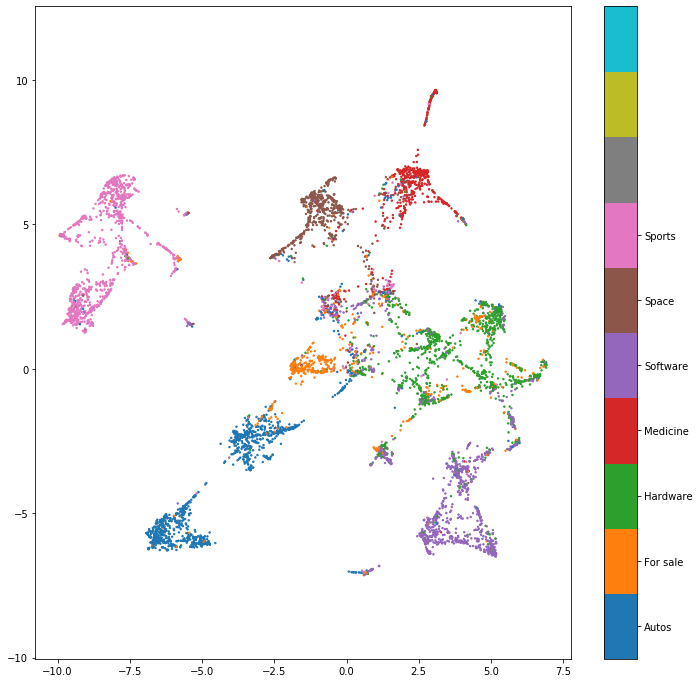

In [7]:
groups = obj['hist']['group']
groups_set = sorted(set(groups))
colors = {v: i for i, v in enumerate(groups_set)}

plt.figure(figsize=(12, 12))
plt.scatter(*np.array(obj['X']).T, s=2, c=list(map(colors.get, groups)), cmap='tab10', vmin=0, vmax=10);
cb = plt.colorbar()
cb.set_ticks(np.arange(len(groups_set)) + .5)
cb.set_ticklabels(groups_set)
plt.axis('equal');

# Deploy the model

In [8]:
labels = df.set_index('_id').iloc[:5000].group.to_dict()

cm.ChisslMongo()\
    .deploy('20 Newsgroups (nmf)', 'test', labels, drop=True);

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Predict on "new" data

In [9]:
cm.ChisslMongo()\
    .get_induction_model('20 Newsgroups (nmf)', 'test')\
    .predict(df.iloc[-30:].to_dict(orient='records'))

C:\Users\gabri\Anaconda3\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\..\..\..\Anaconda3\lib\site-packages\umap\nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
C:\Users\gabri\Anaconda3\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\..\..\..\Anaconda3\lib\site-packages\umap\nndescent.py", li

array(['Software', 'Medicine', 'Space', 'Software', 'Sports', 'Autos',
       'Software', 'Hardware', 'Sports', 'Space', 'Sports', 'Autos',
       'Hardware', 'Autos', 'Autos', 'Software', 'Sports', 'Software',
       'Sports', 'Sports', 'Sports', 'For sale', 'Hardware', 'Hardware',
       'Medicine', 'For sale', 'Medicine', 'Hardware', 'Hardware',
       'Autos'], dtype=object)

In [10]:
cm.ChisslMongo()\
    .get_induction_model('20 Newsgroups (nmf)', 'test')\
    .predict([{'content': 'in want to sell my old honda'}])

array(['Autos'], dtype=object)